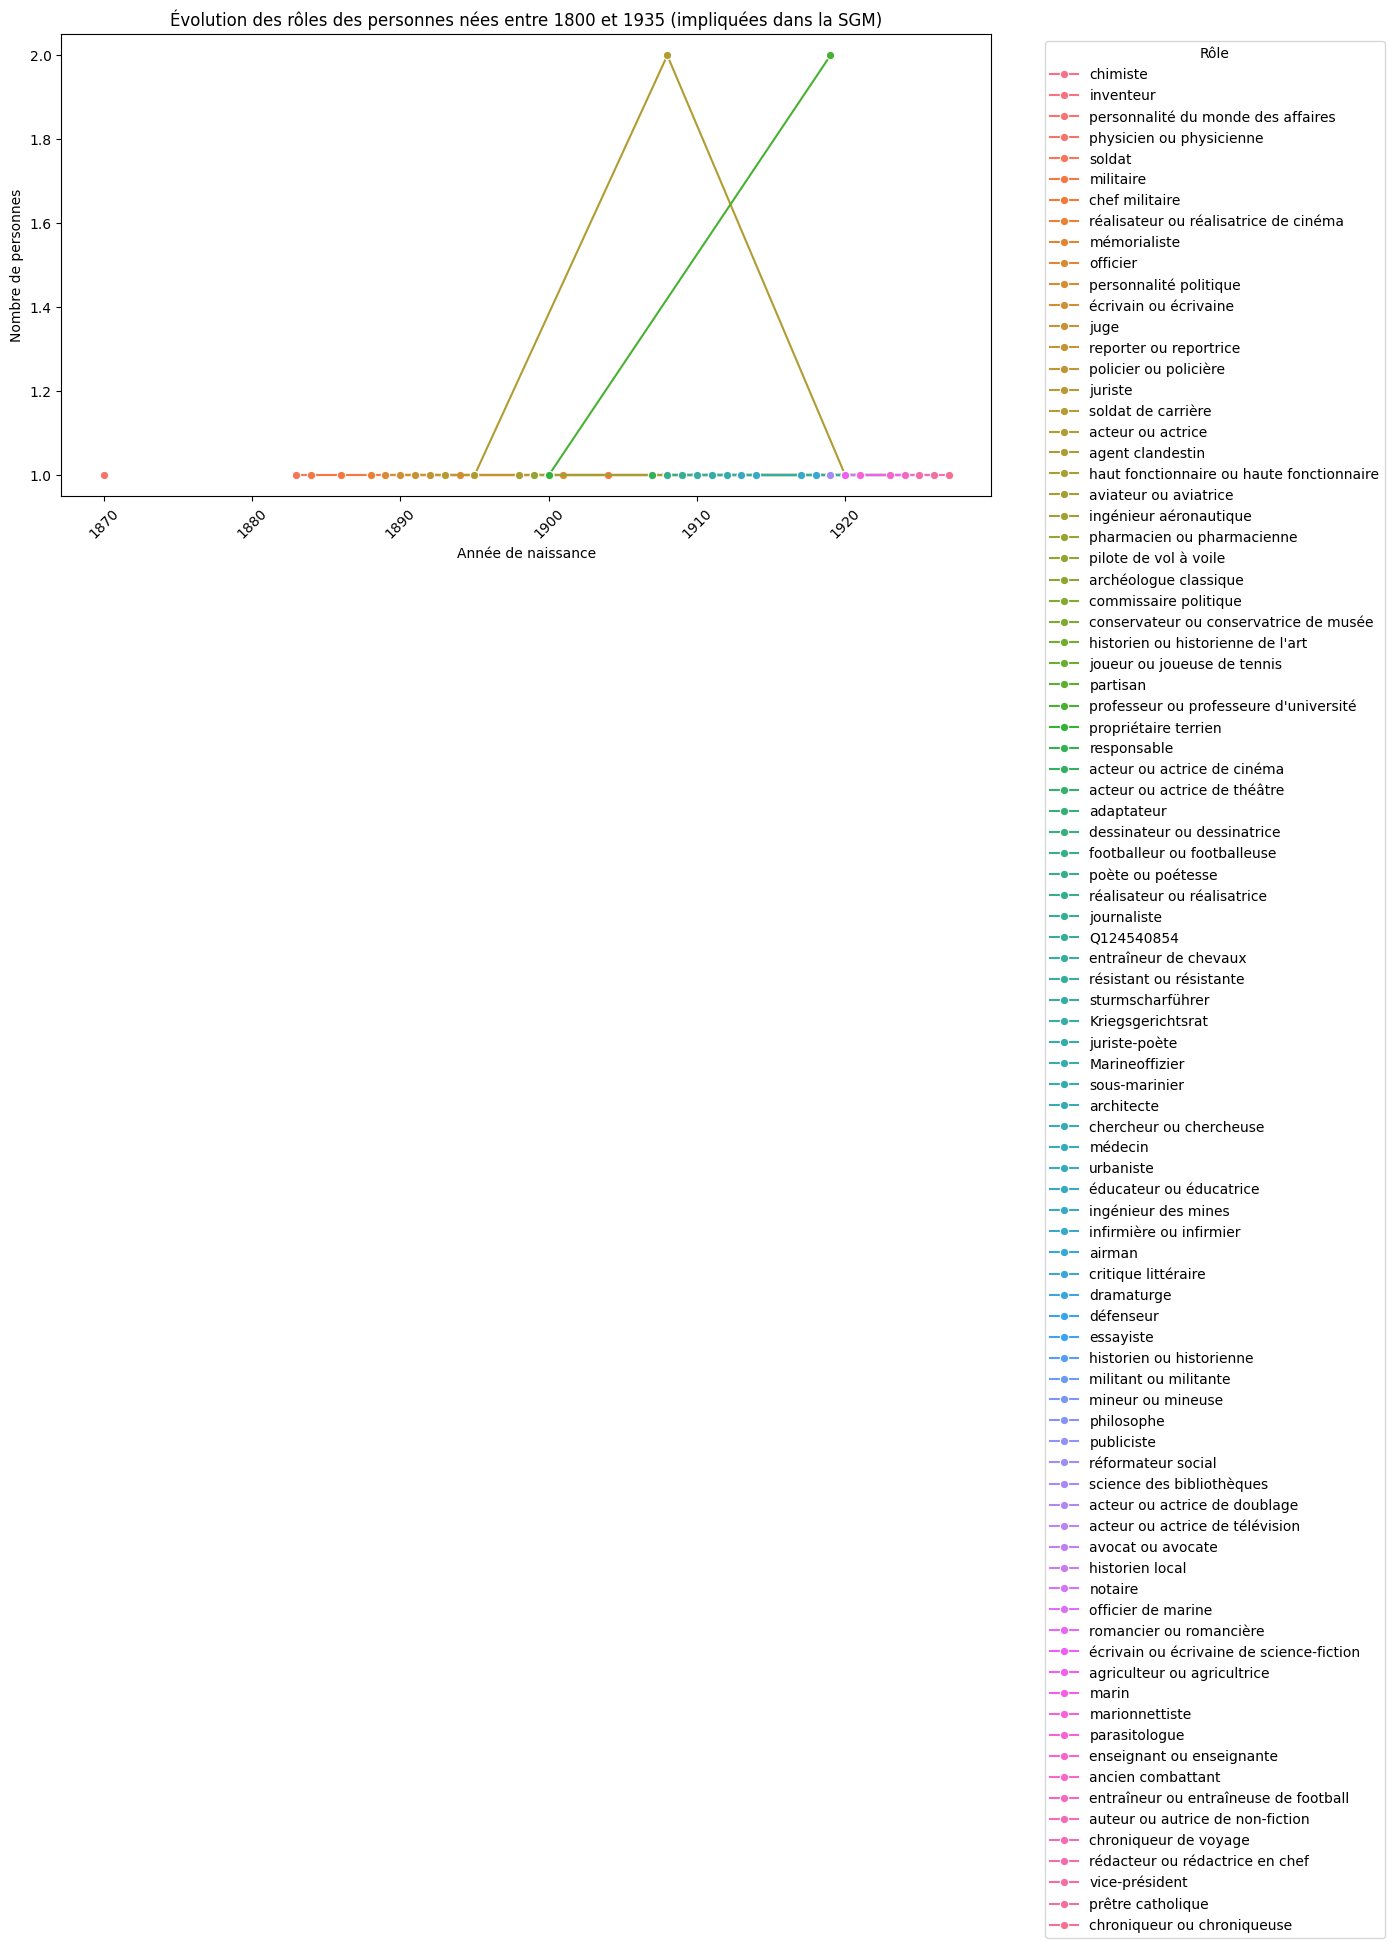

In [8]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# --- Requête SPARQL ---
sparql_query = """

PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT ?person ?personLabel ?birthYear ?roleLabel WHERE {
  ?person wdt:P31 wd:Q5;
          wdt:P1344 wd:Q362;
          wdt:P106 ?role.
  OPTIONAL { ?person wdt:P569 ?birth. BIND(YEAR(?birth) AS ?birthYear) }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "fr,en". }
}

"""

# --- Envoi de la requête à Wikidata ---
url = "https://query.wikidata.org/sparql"
headers = {"Accept": "application/sparql-results+json"}
r = requests.get(url, params={'query': sparql_query}, headers=headers)
data = r.json()

# --- Transformation en DataFrame ---
rows = data['results']['bindings']
records = []
for row in rows:
    if 'birthYear' in row and 'roleLabel' in row:
        records.append({
            'person': row['personLabel']['value'],
            'birthYear': int(row['birthYear']['value']),
            'role': row['roleLabel']['value']
        })

df = pd.DataFrame(records)

# --- Filtrage temporel (période 1935–1950) ---
df = df[(df['birthYear'] >= 1800) & (df['birthYear'] <= 1935)]

# --- Comptage par année et rôle ---
grouped = df.groupby(['birthYear', 'role']).size().reset_index(name='count')

# --- Visualisation ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='birthYear', y='count', hue='role', marker="o")
plt.title("Évolution des rôles des personnes nées entre 1800 et 1935 (impliquées dans la SGM)")
plt.xlabel("Année de naissance")
plt.ylabel("Nombre de personnes")
plt.xticks(rotation=45)
plt.legend(title="Rôle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

